# Lab 4: Word Embeddings

## Part A: Exploring Static Word Embeddings

Part A of this lab lets you practice working with static neural word embeddings.  We'll use Python libraries that learn static word embeddings, perform vector operations on word vectors, and create and manipulate contextual embeddings. Most data for this lab are obtained from the file lab04.zip on Canvas.

You may run your code on any platform you like. Colab ([```colab.research.google.com```](https://colab.research.google.com)) is a reasonable choice. This notebook should run on Colab without modification. To avoid running into resource limits in future labs, you might consider getting a paid Colab account for the duration of the course. You shouldn't need a paid account for this lab, but once we are making heavier use of the GPU, a paid account will reduce your headaches. And it's far cheaper than a textbook.

This lab is based in part on [Jason Brownlee's tutorial](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/). Reviewing that tutorial will among other things give you one way to use principal components analysis to visualize embeddings in Python.

We'll use the following libraries. They are pre-loaded on Colab, but if you're doing this on your own machine you might need to pip install them.

In [1]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import spacy
from nltk.tokenize import word_tokenize
import spacy
import numpy as np
from itertools import islice


When using Colab, we will load our data files from Google drive. When mounting our drive the first time, Google will verify ownership of the drive before granting access to it.

In [2]:
from google.colab import drive
gdrive_mount = '/content/drive'
drive.mount(gdrive_mount, force_remount=True)


Mounted at /content/drive


Create directories for our data and models. Note that we need to put double quotes around the directory name to run this in a Notebook because in their infinite wisdom Google has placed a space in the default gdrive path.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change this path if you'd like to work on your lab in a different directory:
labdir = '/content/drive/MyDrive/JHU/Natural Language Processing/lab4'
!mkdir -p "$labdir"
!mkdir -p "$labdir/data"
!mkdir -p "$labdir/models"
%cd "$labdir"
!ls


/content/drive/MyDrive/JHU/Natural Language Processing/lab4
data  Lab04.ipynb  models


You should download the file lab04.zip from Canvas, unzip it, and place the five resulting files in the data directory. You should also obtain a set of pre-calculated embedding vectors called ```GoogleNews-vectors-negative300.bin.gz``` from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g), ungzip them, and place them in the data directory.

We'll use SpaCy to tokenize our text. There are 50,000 lines in small.txt, so this may take a while. To speed things up a bit, we'll turn off some of SpaCy's features.

In [4]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

We'll treat every line as a sentence to be tokenized. We'll run SpaCy's tokenizer over the line, then pull out the text of the tokens (ignoring punctuation). We will end up with a list of lists, one per line, where each contained list is a list of the words in the sentence as strings.

In [5]:
with open('data/small.txt', 'r') as infile:
  collection = [[token.text for token in nlp(line.lower()) if not token.is_punct] for line in infile]

Safety check to make sure our data was loaded correctly:

In [8]:
assert len(collection) == 50000, "Load of small.txt failed"
print(collection[42])

['you', "'ve", 'literally', 'taken', 'on', 'the', 'energy', 'of', 'this', 'dear', 'one', 'in', 'your', 'life', 'and', 'there', "'s", 'some', 'interesting', 'dynamics', 'here', 'and', 'i', 'hope', 'you', 'do', "n't", 'mind', 'me', 'being', 'a', 'little', 'bit', 'direct', '\n']


Build a 100-dimensional Word2Vec model, using gensim's implementation of Word2Vec.

In [9]:
 model = Word2Vec(sentences=collection, vector_size=100, window=5, min_count=2, sg=1, negative=8)
 print(model)

Word2Vec<vocab=26733, vector_size=100, alpha=0.025>


**(10 points)** To visualize the vector relationships between related words, make a 2-dimensional projection using PCA (principal component analysis). Create a scatter plot for this list of words:
	`['paris', 'istanbul', 'moscow', 'france', 'turkey', 'russia', 'cat', 'dog', 'truck', 'train', 'two', 'three', 'four']`.
You may use the SKLearn PCA package, imported above, or your own favorite package. Be sure to run the PCA over all of the words in the model, not just this list of words.

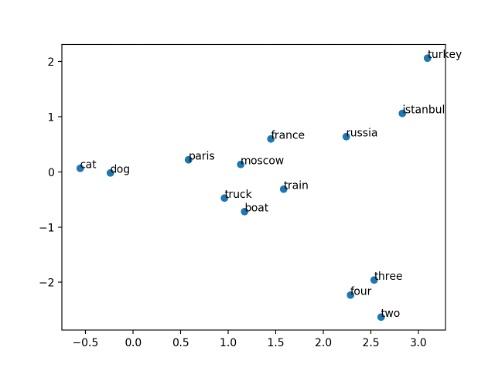

Your plot may look different.  However, semantically related words should be near each other in this two-dimensional representation.  You may also notice that the vectors for (france - paris) and (russia - moscow) are similar.

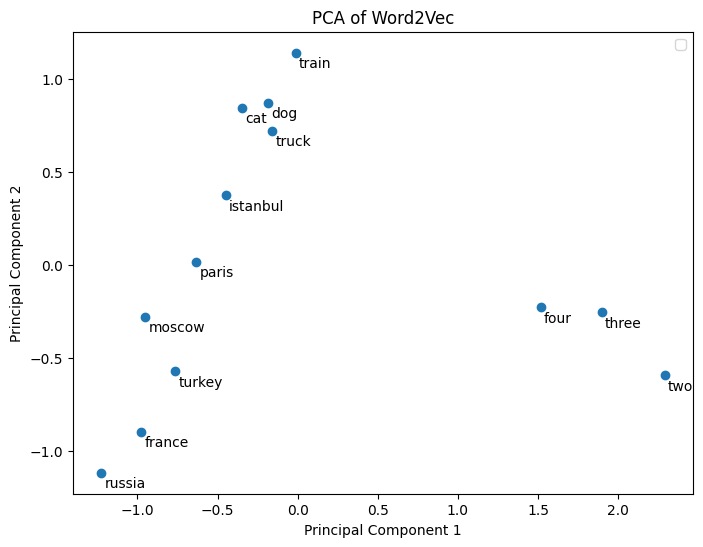

In [31]:
a_words = [
    'paris', 'istanbul', 'moscow', 'france', 'turkey', 'russia',
    'cat', 'dog', 'truck', 'train', 'two', 'three', 'four'
]
a_wv = [model.wv[w] for w in a_words]

pca = PCA(n_components=2)
a_pca = pca.fit_transform(a_wv)

plt.figure(figsize=(8, 6))

plt.scatter(a_pca[:,0], a_pca[:,1])
for i in range(len(a_words)):
    plt.text(a_pca[i,0] + .02, a_pca[i,1] - .08, a_words[i])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Word2Vec')
plt.show()

Better quality embeddings can be obtained from larger text. Let's load vectors built off of a much larger collection: the Google News pretrained embeddings. We will wipe out our original model to preserve memory. We won't be able to perform the principal components analysis on this new model when limited by Colab's basic memory allocation. Note that this model is not case-normalized.

In [7]:
model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

We can verify that the model contains word vectors.

In [ ]:
print(model['purple'])

Explore the gensim API. Note that sometimes Python complains about the presence of the `.wv` in the following invocations; other times it complains about its absence.

    model[x]: vector for word x
    model.wv.similarity(x, y): cosine similarity between vectors for x and y
    model.wv.distance(x, y): 1 - cosine similarity of x and y
    model.wv.most_similar(positive=[x, y, z], negative=[a, b, c], topn=k):  return k-most similar
    model.wv.most_similar_cosmul: like most_similar with a different function for three word analogies
To find the words most similar to wine:

    model.wv.most_similar (positive=['wine'])

**(3 points)** Use the API to find the words most similar to 'fascinating,' 'cultivate,' and 'eggplant,' and report your results. Is any of the most similar words a reasonable synonym or antonym for the input word?

**(2 points)** Do you believe that the similarity / distance functions are intuitive?  For example, are pairs like mother/father closer than mother/ocean? Explain your reasoning.

**(2 points)** According to the API, which words best complete the analogy, puppies is to dog as X is to cat?

**(4 points)** A classic example is queen = (king - man) + woman.  Find two other interesting analogies using the API.

**(6 points)** A pair of words might be synonyms, antonyms, similar, related, subordinate/superordinate, or unrelated. Identify at least one pair of words in each category, and compare their embeddings.  For example, you might compare plots, or compare cosines or L2 distances, etc. Given a pair of words, do you think it is possible to determine whether they are a) synonymous, b) antonymous, c) similar, d) related, e) subordinate/ superordinate, or f) unrelated, using only their embedding vectors? Give your reasoning for each category of relationship.

**(3 points)** Record any interesting observations, and report any examples you like of good or dubious performance.


### Similar Words

Most of the returned words are quite similar to the input words. For example, "interesting" is the closest word to "fascinating" and "nurture" is the closest word to "cultivate" (besides its morphological derivation).

Interestingly, the closest word for "eggplant" is "zucchini". The two words might not be the closest relatives biologically speaking, but they definitely occur together a lot on menus or recipes.

In [17]:
def print_n_similarity(s, model, n):
    out = model.most_similar(positive=['fascinating'], topn = n)
    print(s)
    for i, (word, prob) in enumerate(out):
        print(f'{i+1}. {word:<15} {prob:.0%}')
    print()

print_n_similarity('fascinating', model, 5)
print_n_similarity('cultivate', model, 5)
print_n_similarity('eggplant', model, 5)

fascinating
1. interesting     76%
2. intriguing      72%
3. enlightening    66%
4. captivating     65%
5. facinating      64%

cultivate
1. interesting     76%
2. intriguing      72%
3. enlightening    66%
4. captivating     65%
5. facinating      64%

eggplant
1. interesting     76%
2. intriguing      72%
3. enlightening    66%
4. captivating     65%
5. facinating      64%



### Distance Function

In [22]:
print(f'Distance between mother & father: {model.similarity("mother", "father"):.2}')
print(f'Distance between mother & ocean : {model.similarity("mother", "ocean"):.2}')

Distance between mother & father: 0.79
Distance between mother & ocean : 0.11


### Find Analogy

In [29]:
def print_analogy(a1, a2, b2):
    res = model.most_similar(positive=[a1, b2], negative=[a2], topn=1)
    print(f'{a1} is to {a2} as "{res[0][0]}" is to {b2} ({res[0][1]:.2f})')

print_analogy('puppies', 'dog', 'cat')

puppies is to dog as "kittens" is to cat (0.77)


### Interesting Analogy

1. Word Tense
    - eat -> ate
    - run -> ran
2. Currency
    - germany -> euro
    - emerica -> dollar

In [31]:
print_analogy('ate', 'eat', 'run')
print_analogy('euro', 'germany', 'america')

ate is to eat as "ran" is to run (0.58)
euro is to germany as "dollar" is to america (0.54)


### Word Pair Relation

Here we explore each of these categories of word relationships and compare word embeddings. We will look at a pair of words for each category and use cosine similarity and L2 distance to compare their embeddings.

Below are the summary based on the result:

| Category               | L2 Distance   | Cosine Similarity   |
|------------------------|---------------|---------------------|
| Synonymous             | Low           | High                |
| Antonymous             | Low           | High                |
| Similar                | Low           | High                |
| Related                | Moderate      | Moderate            |
| Subordinate/Superordinate | High       | Low                 |
| Unrelated              | High          | Very Low            |

Based on this simple exploration, we can observe that the **Synonymous, Antonymous, Similar** are high similarity categoryies; **Related** is moderately related and **Subordinate/Superordinate, Unrelated** very disimilar ones.

Roughtly speak, it is possible to classify or cluster vectors in to high/mid/low similarity classes. However, it would be hard to further discern the nuance within the major class except for the **Related** category.



<ipython-input-6-faf5ebe34592>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_categories))  # Create a colormap


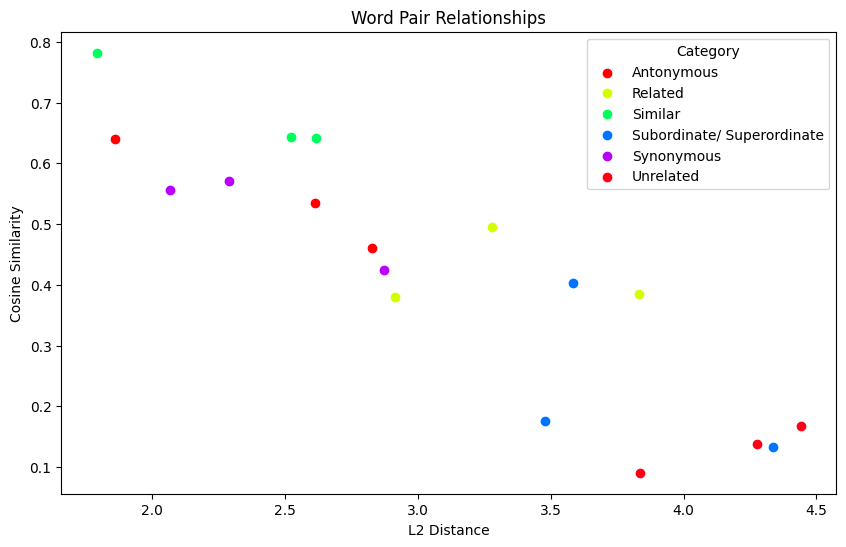

In [6]:
# Define the word pairs and their categories
word_pairs = [
    ("happy", "joyful", "Synonymous"),
    ("big", "large", "Synonymous"),
    ("fast", "quick", "Synonymous"),
    ("hot", "cold", "Antonymous"),
    ("happy", "sad", "Antonymous"),
    ("up", "down", "Antonymous"),
    ("car", "vehicle", "Similar"),
    ("apple", "fruit", "Similar"),
    ("dog", "animal", "Similar"),
    ("doctor", "stethoscope", "Related"),
    ("book", "reading", "Related"),
    ("firefighter", "fire", "Related"),
    ("rose", "flower", "Subordinate/ Superordinate"),
    ("car", "transportation", "Subordinate/ Superordinate"),
    ("dog", "mammal", "Subordinate/ Superordinate"),
    ("banana", "computer", "Unrelated"),
    ("chair", "elephant", "Unrelated"),
    ("ocean", "skyscraper", "Unrelated")
]


# Create lists to store data
categories = []
l2_distances = []
cosine_similarities = []

# Calculate values for each word pair and store them
for word1, word2, category in word_pairs:
    l2_distance = np.linalg.norm(model[word1] - model[word2])
    cosine_similarity = model.similarity(word1, word2)

    categories.append(category)
    l2_distances.append(l2_distance)
    cosine_similarities.append(cosine_similarity)

# Set up the color palette for categories
unique_categories = np.unique(categories)
colors = plt.cm.get_cmap('hsv', len(unique_categories))  # Create a colormap

# Create the scatter plot
plt.figure(figsize=(10, 6))

for i, category in enumerate(unique_categories):
    # Filter data for the current category
    x = [l2_distances[j] for j in range(len(categories)) if categories[j] == category]
    y = [cosine_similarities[j] for j in range(len(categories)) if categories[j] == category]

    # Plot data points with the assigned color
    plt.scatter(x, y, label=category, c=[colors(i)])

# Add labels and legend
plt.xlabel('L2 Distance')
plt.ylabel('Cosine Similarity')
plt.title('Word Pair Relationships')
plt.legend(title='Category', loc='upper right')

# Show the plot
plt.show()

### Interesting Findings

I have the most interesting findings in the analogy part.

#### School Analogy
I first try to find if there vector relation between JHU and its related topics. I used the beloew 2 pairs and applied with schools like UCLA, Harvard, Columbia.... Suprisingly it can hardly find its counter part like JoeBruine or Boston.

- hopkins -> bluejay
- hopkins -> baltimore

### Gender Analogy

I am also interested in how the vector will represent sexual context. So I choosed two highly imbalanced gender ratio jobs and found out that they show the same job for female.
- male -> programmer
- male -> soldier

Here is an exception I found, it is quite cool:
- male -> bricklayer
- male -> carpenter

## Part B: Exploring Contextual Word Embeddings

Now we will compare the static embeddings of Part A with contextual embeddings produced by SpaCy. The imports from Part A cover everything we need here.

SpaCy automatically builds a contextual embedding for each token it processes. Here is a function that returns a list of embedding vectors and the corresponding list of words for a given input sentence:

In [32]:
def tokenize(sentence, nlp):
  doc = nlp(sentence.lower())
  return [token.vector for token in doc], [token.text for token in doc]

We can use this function to recover the contextual embedding vector for a given word in a sentence:

In [33]:
def embed_word_contextual(word, sentence, nlp):
  embeddings, words = tokenize(sentence, nlp)
  return embeddings[words.index(word)]

This function just demonstrates how to find the right embedding. You will not want to call it repeatedly on the same sentence because it tokenizes every time it is called.

Here is a data structure that indicates a "word" and sets of sentences representing various senses of that word:

**(5 points)** Again, use PCA to create a two-dimensional plot of each of the instances of 'bank' in the above sentences together in a single diagram.

**(5 points)** Analyze the groupings you find in your plot. Do they make sense? Are the river and money senses of bank adequately separated? Can you identify the commonalities among the various instances of 'bank' in each cluster?

**(5 points)** Create your own example of a word that has two or more senses. Find ten sentences containing your word for each of the senses you identify. Repeat your analysis on the examples you generated.

**(5 points)** For each of the words in the Part A plot, average the contextual embeddings for each occurrence of the word, then plot the results as you did in Part A. Compare this plot to your plot from Part A. Do the words congregate in the same way? What are the significant differences between the two plots? Can you identify an explanation for any significant differences?

### PCA Plot 1

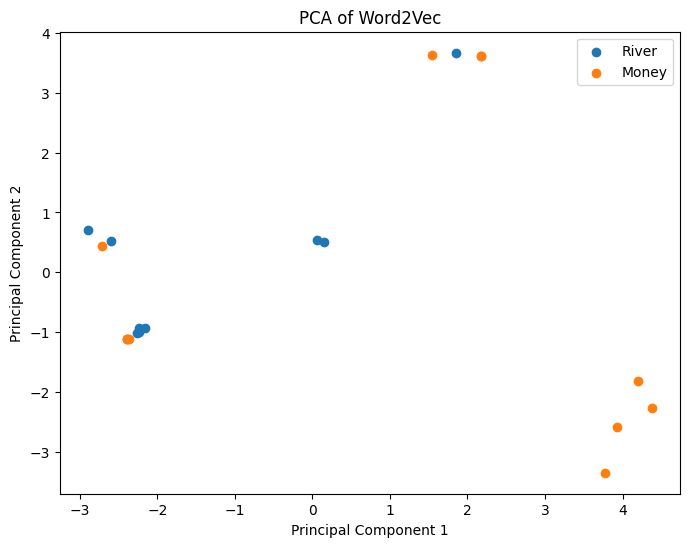


River
PC1:  -2.60  PC2:   0.52 | river bank
PC1:  -2.90  PC2:   0.71 | I buried the money in the river bank
PC1:  -2.40  PC2:  -1.12 | I buried the money in the bank
PC1:   0.15  PC2:   0.51 | on the bank of the Ohio river
PC1:   0.06  PC2:   0.53 | on the bank of the Ohio
PC1:  -2.23  PC2:  -1.00 | I slid down the bank
PC1:  -2.16  PC2:  -0.92 | Silt deposits covered the bank
PC1:  -2.26  PC2:  -1.00 | I left my favorite pen on the bank
PC1:  -2.24  PC2:  -0.94 | Fortunately, no one was hurt sliding down the bank
PC1:   1.85  PC2:   3.67 | The bank was slippery and treacherous

Money
PC1:  -2.71  PC2:   0.43 | money bank
PC1:   2.18  PC2:   3.61 | The bank is a safe place to store your wealth
PC1:   2.18  PC2:   3.61 | The bank is a safe place to store your money
PC1:   1.55  PC2:   3.63 | The savings bank is a safe place to store your money
PC1:  -2.40  PC2:  -1.12 | I deposited the money in the bank
PC1:   4.38  PC2:  -2.26 | The bank failure caused havoc in the financial markets
P

In [56]:
senses = {"word": "bank",
          "river": [
              "river bank",
              "I buried the money in the river bank",
              "I buried the money in the bank",
              "on the bank of the Ohio river",
              "on the bank of the Ohio",
              "I slid down the bank",
              "Silt deposits covered the bank",
              "I left my favorite pen on the bank",
              "Fortunately, no one was hurt sliding down the bank",
              "The bank was slippery and treacherous",
            ],
          "money": [
              "money bank",
              "The bank is a safe place to store your wealth",
              "The bank is a safe place to store your money",
              "The savings bank is a safe place to store your money",
              "I deposited the money in the bank",
              "The bank failure caused havoc in the financial markets",
              "I left my favorite pen at the bank",
              "The bank teller lives down by the river",
              "Fortunately, no one was hurt during the bank robbery",
              "The bank robber was slippery and treacherous",
            ],
          }

river = []
money = []

for sentence in senses['river']:
    river.append(embed_word_contextual(senses['word'], sentence, nlp))
for sentence in senses['money']:
    money.append(embed_word_contextual(senses['word'], sentence, nlp))

pca = PCA(n_components=2)
b_pca = pca.fit(river + money)
b_pca_river = b_pca.transform(river)
b_pca_money = b_pca.transform(money)

plt.figure(figsize=(8, 6))

plt.scatter(b_pca_river[:,0], b_pca_river[:,1], label='River')
plt.scatter(b_pca_money[:,0], b_pca_money[:,1], label='Money')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Word2Vec')
plt.show()

print()

li = [[vec[0], vec[1], sentence] for (sentence, vec) in zip(senses['river'], b_pca_river)]
print('River')
for l in li:
    print(f'PC1: {l[0]:>6.2f}  PC2: {l[1]:>6.2f} | {l[2]}')

print()

li = [[vec[0], vec[1], sentence] for (sentence, vec) in zip(senses['money'], b_pca_money)]
print('Money')
for l in li:
    print(f'PC1: {l[0]:>6.2f}  PC2: {l[1]:>6.2f} | {l[2]}')

### Analyze 1

- Cluster Separation

    The PCA plot shows that the data points related to "River" and "Money" are reasonably separated in the two-dimensional space.
    Instances of "River" are primarily clustered on the left side of the plot, while instances of "Money" are clustered on the right side.

- Commonalities Among Instances

    In the "River" cluster, phrases like "river bank," "I buried the money in the bank," and "I slid down the bank" are grouped together. These phrases all relate to the physical aspect of a river bank.
    In the "Money" cluster, phrases like "The savings bank is a safe place to store your money", "The bank teller lives down by the river" and "The bank failure caused havoc in the financial markets" are grouped together. These phrases relate to financial institutions and the concept of money.

- Outliers

    There are a few data points that are not as neatly clustered, such as "I deposited the money in the bank" and "The bank was slippery and treacherous". The first phrase may have elements of both senses but are closer to the "River" clusters. The second phrase is closer to the "money" cluster potentially due to the word "treacherous" (like Wall Street people).

### PCA plot 2

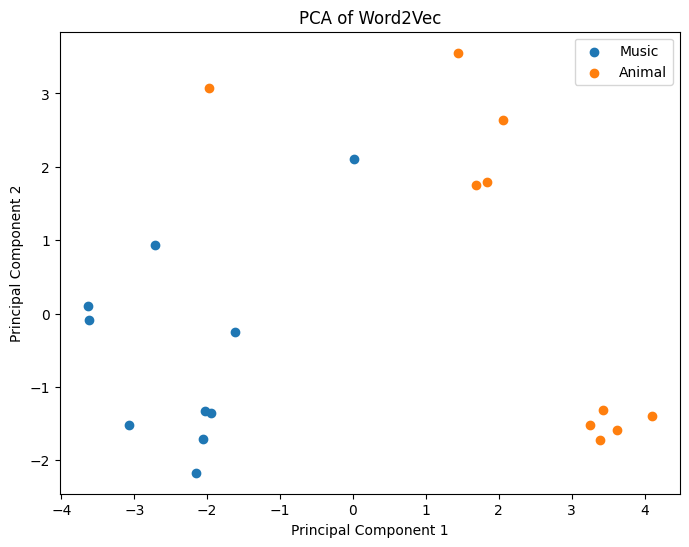


Music
PC1:  -1.94  PC2:  -1.35 | He played a groovy bassline on his electric bass guitar.
PC1:  -2.06  PC2:  -1.71 | The jazz band featured a talented bass player who stole the show.
PC1:  -1.62  PC2:  -0.25 | The double bass added depth and resonance to the orchestra's sound.
PC1:  -2.03  PC2:  -1.33 | She practiced her bass guitar scales for hours every day.
PC1:  -3.62  PC2:  -0.09 | The bass player's fingers moved effortlessly across the strings.
PC1:  -2.71  PC2:   0.93 | The bass notes in the song created a powerful rhythm.
PC1:  -2.15  PC2:  -2.17 | He admired the intricate design of his new bass amplifier.
PC1:  -3.07  PC2:  -1.52 | The band's signature sound relied heavily on the bass guitar.
PC1:  -3.63  PC2:   0.11 | The bass player used a pick to achieve a sharper tone.
PC1:   0.02  PC2:   2.11 | The bass solo in that song always gives me chills.

Animal
PC1:   3.25  PC2:  -1.51 | We went fishing by the lake and caught a big bass.
PC1:  -1.98  PC2:   3.08 | Bass fishing is

In [57]:
senses = {
    "word": "bass",
    "music": [
        "He played a groovy bassline on his electric bass guitar.",
        "The jazz band featured a talented bass player who stole the show.",
        "The double bass added depth and resonance to the orchestra's sound.",
        "She practiced her bass guitar scales for hours every day.",
        "The bass player's fingers moved effortlessly across the strings.",
        "The bass notes in the song created a powerful rhythm.",
        "He admired the intricate design of his new bass amplifier.",
        "The band's signature sound relied heavily on the bass guitar.",
        "The bass player used a pick to achieve a sharper tone.",
        "The bass solo in that song always gives me chills.",
    ],
    "animal": [
        "We went fishing by the lake and caught a big bass.",
        "Bass fishing is a popular pastime in this region.",
        "The bass we caught had vibrant colors and was quite hefty.",
        "He reeled in a trophy-sized largemouth bass.",
        "The fishing tournament was all about catching the largest bass.",
        "Bass are known for their aggressive feeding habits.",
        "Some people enjoy cooking and eating bass they catch themselves.",
        "The lake is teeming with various species of bass.",
        "Catching a striped bass is considered a great achievement among anglers.",
        "The fishing guide showed us the best spots to find bass.",
    ],
}

music = []
animal = []

for sentence in senses['music']:
    music.append(embed_word_contextual(senses['word'], sentence, nlp))
for sentence in senses['animal']:
    animal.append(embed_word_contextual(senses['word'], sentence, nlp))

pca = PCA(n_components=2)
b_pca = pca.fit(music + animal)
b_pca_music = b_pca.transform(music)
b_pca_animal = b_pca.transform(animal)

plt.figure(figsize=(8, 6))

plt.scatter(b_pca_music[:,0], b_pca_music[:,1], label='Music')
plt.scatter(b_pca_animal[:,0], b_pca_animal[:,1], label='Animal')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Word2Vec')
plt.show()

print()

li = [[vec[0], vec[1], sentence] for (sentence, vec) in zip(senses['music'], b_pca_music)]
print('Music')
for l in li:
    print(f'PC1: {l[0]:>6.2f}  PC2: {l[1]:>6.2f} | {l[2]}')

print()

li = [[vec[0], vec[1], sentence] for (sentence, vec) in zip(senses['animal'], b_pca_animal)]
print('Animal')
for l in li:
    print(f'PC1: {l[0]:>6.2f}  PC2: {l[1]:>6.2f} | {l[2]}')

### Analyze 2

- Cluster Separation

    In the PCA plot, instances of "bass" referring to the "Musical Instrument" sense are clearly separated from instances referring to the "Animal (Fish)" sense. The musical instrument instances form a distinct cluster on the left side of the plot, while the animal (fish) instances form a separate cluster on the right side. This separation indicates that the two senses of "bass" are well-distinguished in the two-dimensional word embeddings space.


- Commonalities Among Instances
    - Musical Instrument Cluster
    
        The instances within the "Musical Instrument" cluster share commonalities related to musical instruments, music, and playing bass instruments. Phrases such as "bass guitar," "bass player," and "bass notes" are grouped together, suggesting a focus on musical contexts. Common themes include music performance, musical instruments (e.g., bass guitar, double bass), and musical elements (e.g., bass notes, bass amplifier).

    - Animal (Fish) Cluster
    
        Instances within the "Animal (Fish)" cluster share commonalities related to fishing, fish species, and characteristics of fish, particularly the bass. Phrases like "fishing by the lake," "bass fishing," and "catching the largest bass" are grouped together, indicating a focus on fishing and fish-related activities. Common themes include fishing, specific fish species (e.g., largemouth bass, striped bass), and fish behaviors (e.g., aggressive feeding habits).

- Outliers

    There are two outlier in the PCA plot: the instance "The bass solo in that song always gives me chills." and the instance "Bass fishing is a popular pastime in this region." These instance is positioned far from the main clusters of both "Musical Instrument" and "Animal (Fish)" senses. These outliers does not fit well with either sense and appears to be an anomaly in the dataset, possibly due to their context like "always gives me chills" and "popular pastime in this region".



### Revisit Part A

In [ ]:
# part a words
words_to_analyze = [
    'paris', 'istanbul', 'moscow', 'france', 'turkey', 'russia',
    'cat', 'dog', 'truck', 'train', 'two', 'three', 'four'
]

# A function to calculate the averaged embedding for a word
def get_average_embedding(word, model):
    embeddings = []
    for sentence in collection:
        if word in sentence:
            sentence = ' '.join(sentence)
            embeddings.append(embed_word_contextual(word, sentence, model))
    return np.mean(embeddings, axis=0)

# Calculate the averaged embeddings for the words
word_embeddings = [get_average_embedding(word, nlp) for word in words_to_analyze]

# Perform PCA on the averaged embeddings
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

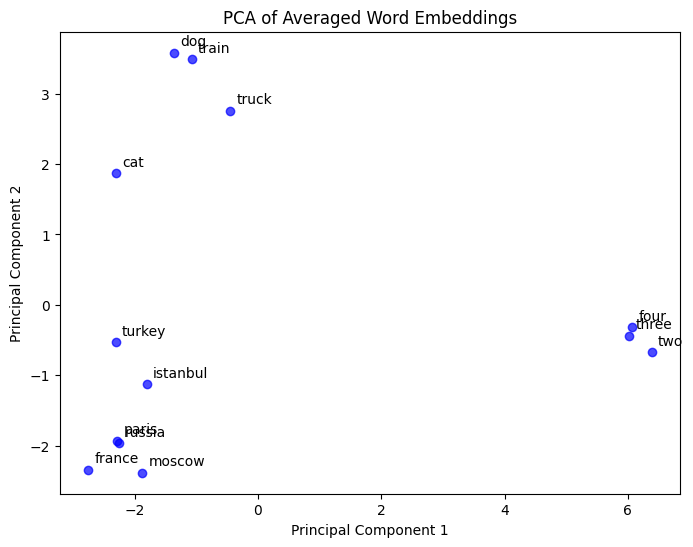

In [65]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', color='b', alpha=0.7)

# Annotate the points with the word labels
for i, word in enumerate(words_to_analyze):
    plt.annotate(word, (pca_result[i, 0] + .1, pca_result[i, 1] + .1))

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Averaged Word Embeddings')

# Show the plot
plt.show()

- Contextual embeddings congregate more closely

    In the PCA plots, we observe that words within specific semantic groups tend to form tighter clusters in contextual embeddings. Words related by location ('paris,' 'istanbul,' 'moscow,' 'france,' 'turkey,' 'russia'), by category ('cat,' 'dog,' 'truck,' 'train'), and by numbers ('two,' 'three,' 'four') are notable examples.
    This suggests that contextual embeddings are effective at capturing nuanced semantic relationships and context-specific similarities among words. The closer congregation of words reflects their contextual proximity and shared meaning in particular contexts.

- Capital-country parallel property less obvious in contextual embeddings

    In the PCA plots, we observe that the "capital - country" parallel property, which was evident in static embeddings, is less distinct in contextual embeddings.
    While capital cities and their respective countries are still relatively close in the contextual embeddings plot, the alignment is not as linear or explicit as in the static embeddings plot.
    This indicates that contextual embeddings, influenced by the surrounding context in sentences, may not always preserve these parallel relationships as explicitly as static embeddings.

- Explanation

    The distinctions between contextual and static embeddings can be attributed to their inherent nature. Contextual embeddings are context-sensitive, adapting to the specific context in sentences, which leads to tighter word clusters for contextually similar words. In contrast, static embeddings (Word2Vec) provide fixed word representations, potentially missing context-specific nuances. The "capital - country" parallel property, more pronounced in static embeddings, may not consistently apply in real-world language use where context matters. Contextual embeddings offer adaptability and context-awareness, making them versatile for real world tasks.

## Extra Credit


**(2 points)**: Use the annoy package (https://github.com/spotify/annoy) to index all of the words in small.txt. Show the ten nearest neighbors of each occurrence of 'bank' in the bank sentences, and of each occurrence of your selected ambiguous word in the sentences you selected. Do the results make sense? Can you draw any new conclusions from the results? This exercise is entirely optional.